In [178]:
import numpy as np 
import matplotlib.pylab as plt 
from scipy.integrate import odeint
import torch 

from deepymod_torch.library_function import library_ODE,library_1D_in
from deepymod_torch.DeepMod import DeepMoD
from deepymod_torch.neural_net import train_group, deepmod_init
from deepymod_torch.sparsity import scaling, threshold
from deepymod_torch.utilities import terms_definition
try:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
except:
    pass

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate some ODE data

In [179]:
t = np.linspace(0, 20, 101)

In [180]:
def pend(y, t, b, c):
    theta, omega = y
    dydt = [omega, -b*omega - c*theta]
    return dydt

In [181]:
y0 = [np.pi - 0.1, 0.0]

In [182]:
b, c = 0.1, 2

In [183]:
sol = odeint(pend, y0, t, args=(b, c))

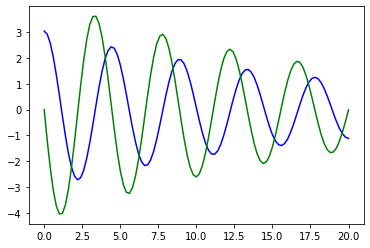

In [184]:
plt.plot(t, sol[:, 0], 'b', label='theta(t)')
plt.plot(t, sol[:, 1], 'g', label='omega(t)')

In [185]:
y_full = sol
x_full = t.reshape(-1,1)

In [186]:
print(x_full.shape,y_full.shape)

(101, 1) (101, 2)


# DeepMoD

In [199]:
num_samples = 50
rand_idx = np.random.permutation(x_full.shape[0])[:num_samples]

X_train = torch.tensor(x_full[rand_idx, :], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_full[rand_idx, :], dtype=torch.float32, requires_grad=True)

In [209]:
network_config = {'input_dim': 2, 'hidden_dim': 20, 'layers': 3, 'output_dim': y_train.shape[1]}
optim_config = {'lambda': 10**-5, 'max_iterations': 5001}
library_config = {'type': library_1D_in, 'poly_order': 2, 'diff_order': 0}

In [210]:
network, coeff_vector_list, sparsity_mask_list = deepmod_init(network_config, library_config)

6


RuntimeError: shape '[1, 6]' is invalid for input of size 9

In [211]:
poly_list = [['','u'], ['','v'], ['', 'w']]
deriv_list = [['', 'u_x'], ['', 'v_x'], ['', 'w_x']]

In [148]:
from itertools import product, chain
from functools import reduce

In [149]:
def string_matmul(list_1, list_2):
    prod = [element[0] + element[1] for element in product(list_1, list_2)]
    return prod

In [151]:
theta_uv = reduce((lambda x, y: string_matmul(x, y)), poly_list)
theta_uv

['', 'w', 'v', 'vw', 'u', 'uw', 'uv', 'uvw']

In [165]:
string_matmul

<function __main__.string_matmul(list_1, list_2)>

In [159]:
reduce(string_matmul, poly_list[0])

['', 'w', 'v', 'vw', 'u', 'uw', 'uv', 'uvw']

In [163]:
poly_list[0]

['', 'u']

In [164]:
combinations(poly_list,2)

In [152]:
theta_dudv = reduce((lambda x, y: string_matmul(x, y)[1:]), deriv_list)
theta_dudv

['v_xw_x', 'u_x', 'u_xw_x', 'u_xv_x', 'u_xv_xw_x']

In [153]:
theta_udv = list(chain.from_iterable([string_matmul(u[1:], dv[1:]) for u, dv in product(poly_list, deriv_list)]))
theta_udv

['uu_x', 'uv_x', 'uw_x', 'vu_x', 'vv_x', 'vw_x', 'wu_x', 'wv_x', 'ww_x']

In [154]:
[element for element in (theta_uv + theta_dudv + theta_udv)]

['',
 'w',
 'v',
 'vw',
 'u',
 'uw',
 'uv',
 'uvw',
 'v_xw_x',
 'u_x',
 'u_xw_x',
 'u_xv_x',
 'u_xv_xw_x',
 'uu_x',
 'uv_x',
 'uw_x',
 'vu_x',
 'vv_x',
 'vw_x',
 'wu_x',
 'wv_x',
 'ww_x']

In [ ]:
def terms_definition(poly_list, deriv_list):
    theta_uv = [string_matmul(u, v) for u, v in combinations(poly_list, 2)]
    theta_dudv = [string_matmul(du, dv)[1:] for du, dv in combinations(deriv_list, 2)]
    theta_udv = [string_matmul(u[1:], dv[1:]) for u, dv in product(poly_list, deriv_list)]
    theta = [element for theta_specific in (theta_uv + theta_dudv + theta_udv) for element in theta_specific]